# Experiments for different Methods of Compressed Sensing 

### Importing modules and data

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import dct,idct
import cvxpy as cvx
import idx2numpy
import random
from sklearn.decomposition import PCA
from sklearn import linear_model
import time
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
with open("gray_images_cifar","rb") as f:
    cifar_data=pickle.load(f, encoding='bytes')

In [4]:
with open("gray_images_cifar","rb") as f:
    cifar_data=pickle.load(f, encoding='bytes')
    
mnist_data=idx2numpy.convert_from_file("images_mnist.idx3-ubyte")/255

In [5]:
print(cifar_data.shape,mnist_data.shape)

(60000, 32, 32) (60000, 28, 28)


C:\Users\phili\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


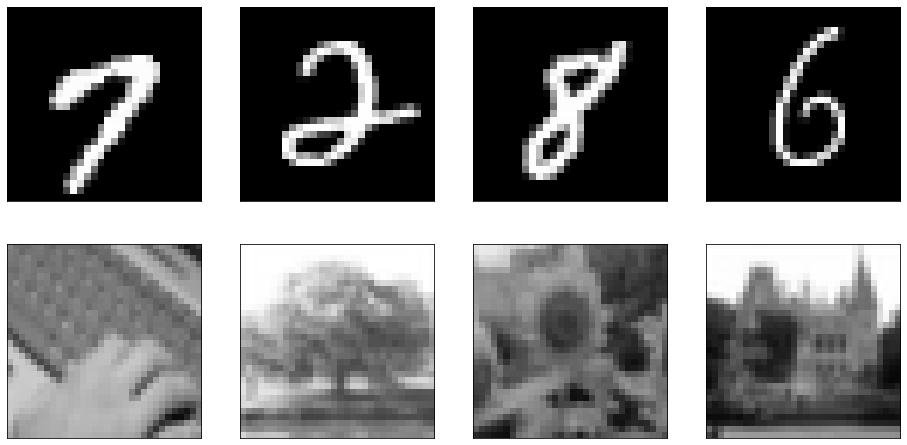

In [6]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8))
for i in range(4):
    axs[0][i].imshow(mnist_data[i+15],cmap="gray", vmin=0, vmax=1)
    axs[0][i].tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)
    axs[1][i].imshow(cifar_data[i+10],cmap="gray", vmin=0, vmax=1)
    axs[1][i].tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)

fig.show()

### Defining functions

In [7]:
def PSNR(im1, im2):
    return -10*np.log10(((im1-im2)**2).mean())

def compress(im,k):
    im_vec=abs(im)
    if k>(im_vec>0).sum():
        return im_vec
    
    n=len(im_vec)
    threshold=np.percentile(im_vec,100*(n-k)/n)-1e-10
    im_vec[im_vec<threshold]=0
    
    num_left=(im_vec>0).sum()-k
    while num_left>0:
        threshold=np.min(im_vec[im_vec>0])
        indexes=np.where(im_vec==threshold)[0]
        random.shuffle(indexes)
        for l in range(min(num_left,len(indexes))):
            im_vec[indexes[l]]=0
        num_left=num_left-min(num_left,len(indexes))

    im[im_vec==0]=0
    return im

def sparsity(data, k_max=np.inf, k_inc=1, transform=None, inv_transform=None, sample_size=10):
    #100 samples were used originally
    
    psnr_list=[]
    k_max=int(np.min([k_max,len(data[0])]))
    sample_size=int(min(sample_size,len(data)))
    
    if transform is not None:
        trans=transform(data[50000:])
    else:
        trans=data[50000:]
    
    for k in range(1,k_max,k_inc):
        sample=trans[:sample_size].copy()
        for j in range(sample_size):
            compress(sample[j],k)
            
        if inv_transform is not None:
            sample=inv_transform(sample)
            
        psnr=PSNR(data[50000:50000+sample_size],sample)
        
        if psnr>100:
            break
            
        psnr_list.append(psnr)
        
    return psnr_list

def reconstruct(img, transform, sparsity=0.1,plot=False,C=None):
    
    n=len(img)
    if C is None:
        C=np.diag(np.random.rand(n)<sparsity).astype(int)
    
    Psi=transform[0]
    inv_Psi=transform[1]
    
    y=C@img
    A=C@inv_Psi
    
    a=0.00005
    vx = cvx.Variable(n)
    objective = cvx.Minimize(a*cvx.pnorm(vx, 1)+ 1/(2*n)*cvx.pnorm(A@vx-y, 2)**2)
    constraints = []
    prob = cvx.Problem(objective, constraints)
    result = prob.solve(verbose=False)
    s=np.array(vx.value).squeeze()
    x=inv_Psi@s
    
    
    
    if plot:
        x=x.reshape(int(np.sqrt(n)),int(np.sqrt(n)))
        plt.imshow(s.reshape(int(np.sqrt(n)),int(np.sqrt(n))),cmap="gray", vmin=-0.1, vmax=0.1)
        plt.show()
        plt.imshow(y.reshape(int(np.sqrt(n)),int(np.sqrt(n))),cmap="gray", vmin=0, vmax=1)
        plt.show()
        plt.imshow(x,cmap="gray",vmin=0, vmax=1)
        plt.show()
        plt.imshow(img.reshape(int(np.sqrt(n)),int(np.sqrt(n))),cmap="gray",vmin=0, vmax=1)
        plt.show()
        print("PSNR=",PSNR(img.reshape(int(np.sqrt(n)),int(np.sqrt(n))),x))
    return x

def test_method(test_data, transform=None, net=None, untrained=None, samples=10, spars=np.arange(0.1,0.8,0.1)): 
    #100 samples were used originally
    
    avg_psnrs=[]
    times=[]
    imgs=test_data[:samples]
    n=len(imgs[0])
    for s in spars:
        psnr_list=[]
        
        for img in imgs:
            
            if transform is not None:
                start = time.time()
                x=reconstruct(img,transform,sparsity=s)
                end=time.time()
            
            if net is not None:
                net.eval()
                start=time.time()
                C=np.diag(np.random.rand(n)<s)
                y=C@img
                mask=torch.tensor((C@np.ones(n)).reshape(int(np.sqrt(n)),int(np.sqrt(n))))
                inp_img=torch.tensor(img.reshape(int(np.sqrt(n)),int(np.sqrt(n))))
                inp_img[(1-mask).bool()]=0
                inp=torch.stack((inp_img, 1-mask),0).unsqueeze(0).to("cuda")
                x=net.forward(inp).cpu().squeeze().detach().numpy().reshape(n)
                end=time.time()
                
            if untrained is not None:
                start=time.time()
                C=np.diag(np.random.rand(n)<s).astype(int)
                x=untrained(img,C=C).reshape(n)
                end=time.time()
                
            psnr_list.append(PSNR(img,x))
            times.append(end - start)
            
            
        avg_psnrs.append(np.mean(psnr_list))
    
    return avg_psnrs,np.mean(times)

class U_Net(nn.Module):
    
    def __init__(self, inp_c=2):
        
        super(U_Net, self).__init__()
        
        #28x28
        self.conv1 = nn.Conv2d(inp_c, 16, 3, padding=1)
        self.bn1=nn.BatchNorm2d(16, momentum=0.01)
        #28x28,x1
        self.pool1=torch.nn.MaxPool2d((2,2))
        #14x14
        self.conv2 = nn.Conv2d(16, 32, 3,  padding=1)
        self.bn2=nn.BatchNorm2d(32, momentum=0.01)
        #14x14,x2
        self.pool2=torch.nn.MaxPool2d((2,2))
        #7x7
        self.conv3_1 = nn.Conv2d(32, 64, 3,  padding=1)
        self.bn3_1=nn.BatchNorm2d(64, momentum=0.01)
        self.conv3_2 = nn.Conv2d(64, 64, 3,  padding=1)
        self.bn3_2=nn.BatchNorm2d(64, momentum=0.01)
        self.conv3_3 = nn.Conv2d(64, 64, 3,  padding=1)
        self.bn3_3=nn.BatchNorm2d(64, momentum=0.01)
        #7x7
        self.upconv1 =nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.bn3_4=nn.BatchNorm2d(32, momentum=0.05)
        #14x14 -> x2
        self.conv4 = nn.Conv2d(64, 32, 3,  padding=1)
        self.bn4_1=nn.BatchNorm2d(32, momentum=0.05)
        #14x14
        self.upconv2 =nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1)
        self.bn4_2=nn.BatchNorm2d(16, momentum=0.05)
        #28x28-> x1
        self.conv5 = nn.Conv2d(32, 16, 3,  padding=1)
        self.outconv = nn.Conv2d(16, 1, 1)
        
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x_1 = x
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x_2=x
        x = self.pool2(x)
        
        x = F.relu(self.conv3_1(x))
        x = self.bn3_1(x)
        x = F.relu(self.conv3_2(x))
        x = self.bn3_2(x)
        x = F.relu(self.conv3_3(x))
        x = self.bn3_3(x)
        x = F.relu(self.upconv1(x))
        x = self.bn3_4(x)

        x = torch.cat((x, x_2), 1)
        x = F.relu(self.conv4(x))
        x = self.bn4_1(x)
        x = self.upconv2(x)
        x = self.bn4_2(x)
        
        x = torch.cat((x, x_1), 1)
        x = F.relu(self.conv5(x))
        
        return torch.sigmoid(self.outconv(x)).squeeze(1)

    
def count_parameters(model):
    """
    Count weights of a PyTorch model.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class U_Net_small(nn.Module):
    
    def __init__(self):
        
        super(U_Net_small, self).__init__()
        
        #28x28
        self.conv1 = nn.Conv2d(1, 4, 3, padding=1)
        self.bn1=nn.BatchNorm2d(4, momentum=0.01)
        #28x28
        self.pool1=torch.nn.MaxPool2d((2,2))
        #14x14
        self.conv2 = nn.Conv2d(4, 8, 3,  padding=1)
        self.bn2=nn.BatchNorm2d(8, momentum=0.01)
        #14x14,x2
        self.pool2=torch.nn.MaxPool2d((2,2))
        #7x7
        self.conv3_1 = nn.Conv2d(8, 16, 3,  padding=1)
        self.bn3_1=nn.BatchNorm2d(16, momentum=0.01)
        self.conv3_2 = nn.Conv2d(16,16, 3,  padding=1)
        self.bn3_2=nn.BatchNorm2d(16, momentum=0.01)
        self.conv3_3 = nn.Conv2d(16, 16, 3,  padding=1)
        self.bn3_3=nn.BatchNorm2d(16, momentum=0.01)
        #7x7
        self.upconv1 =nn.ConvTranspose2d(16, 8, 4, stride=2, padding=1)
        self.bn3_4=nn.BatchNorm2d(8, momentum=0.05)
        #14x14 -> x2
        self.conv4 = nn.Conv2d(16, 8, 3,  padding=1)
        self.bn4_1=nn.BatchNorm2d(8, momentum=0.05)
        #14x14
        self.upconv2 =nn.ConvTranspose2d(8, 8, 4, stride=2, padding=1)
        self.bn4_2=nn.BatchNorm2d(8, momentum=0.05)
        #28x28
        self.conv5 = nn.Conv2d(8, 8, 3,  padding=1)
        self.outconv = nn.Conv2d(8, 1, 1)
        
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x_2=x
        x = self.pool2(x)
        
        x = F.relu(self.conv3_1(x))
        x = self.bn3_1(x)
        x = F.relu(self.conv3_2(x))
        x = self.bn3_2(x)
        x = F.relu(self.conv3_3(x))
        x = self.bn3_3(x)
        x = F.relu(self.upconv1(x))
        x = self.bn3_4(x)

        x = torch.cat((x, x_2), 1)
        x = F.relu(self.conv4(x))
        x = self.bn4_1(x)
        x = self.upconv2(x)
        x = self.bn4_2(x)
        
        x = F.relu(self.conv5(x))
        
        return torch.sigmoid(self.outconv(x)).squeeze(1)
    
def untrained(img, device="cuda", sparsity=0.2, transform=None, C=None):
    
    n=len(img)
    if C is None:
        C=np.diag(np.random.rand(n)<sparsity).astype(int)
    
    if transform is None:
        A=torch.tensor(C).to(device).double()
    else:
        Psi=transform[0]
        inv_Psi=transform[1]
        A=torch.tensor(C@inv_Psi).to(device).double()
    
    #plt.imshow((C@img).reshape(32,32),cmap="gray",vmin=0,vmax=1)
    #plt.show()
    y=torch.tensor(C@img).to(device)
    #print(y,A)
    
    net=U_Net_small().double().to(device)
    opti=optim.Adam(net.parameters(), lr=0.01, weight_decay=0.001)
    inp=torch.tensor(np.random.normal(size=(int(np.sqrt(n)),int(np.sqrt(n))))).unsqueeze(0).unsqueeze(0).double().to(device)
    
    
    for i in range(500):
        s=net.forward(inp)
        s=torch.flatten(s)
        #print(s)
        loss=F.mse_loss(y,A@s)
        opti.zero_grad()
        loss.backward()
        opti.step()
    if transform is None:
        return s.cpu().detach().numpy()
    else:    
        return inv_Psi@s.cpu().detach().numpy()


In [8]:
mnist_data_vec=mnist_data.reshape(60000,784)
pca=PCA()
pca.fit(mnist_data_vec[:50000])

cifar_data_vec=cifar_data.reshape(60000,1024)
pca2=PCA()
pca2.fit(cifar_data_vec[:50000])

DCT_mnist=[dct(np.eye(784), axis=0, norm="ortho"),idct(np.eye(784),axis=0,norm="ortho")]
DCT_cifar=[dct(np.eye(1024), axis=0, norm="ortho"),idct(np.eye(1024),axis=0,norm="ortho")]
PCA_mnist=[pca.transform(np.eye(784)).T,pca.inverse_transform(np.eye(784)).T]
PCA_cifar=[pca2.transform(np.eye(1024)).T,pca2.inverse_transform(np.eye(1024)).T]

C:\Users\phili\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


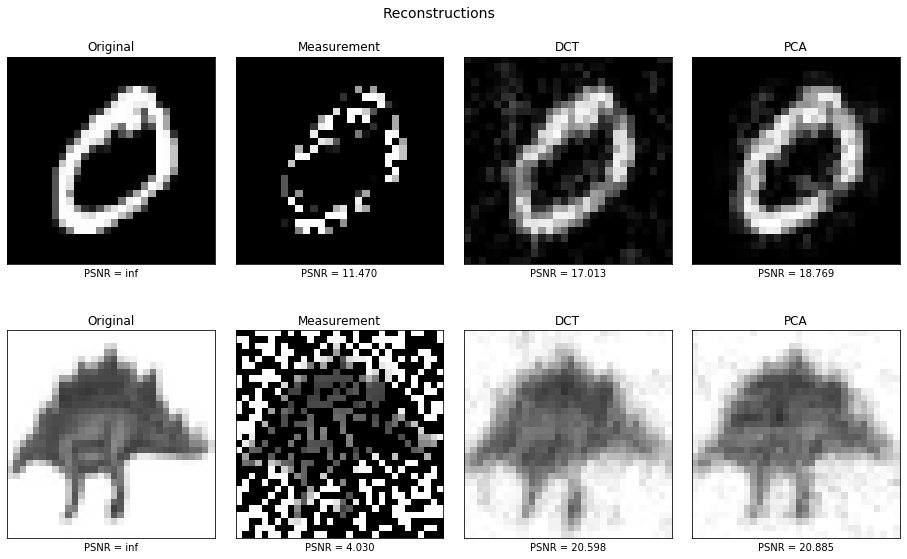

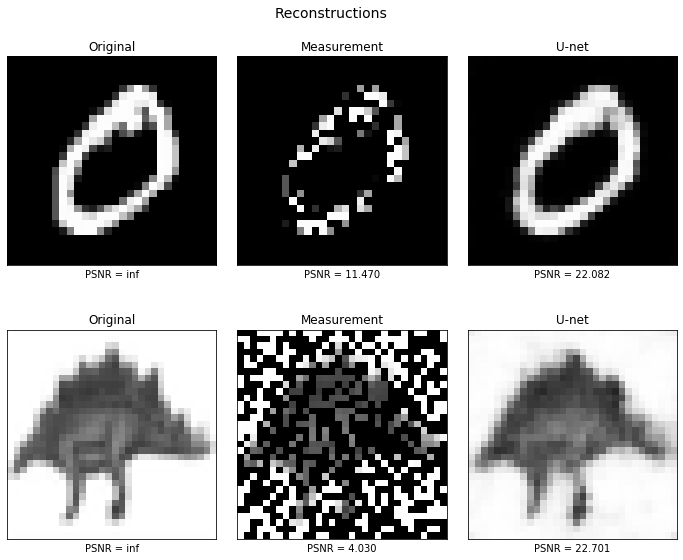

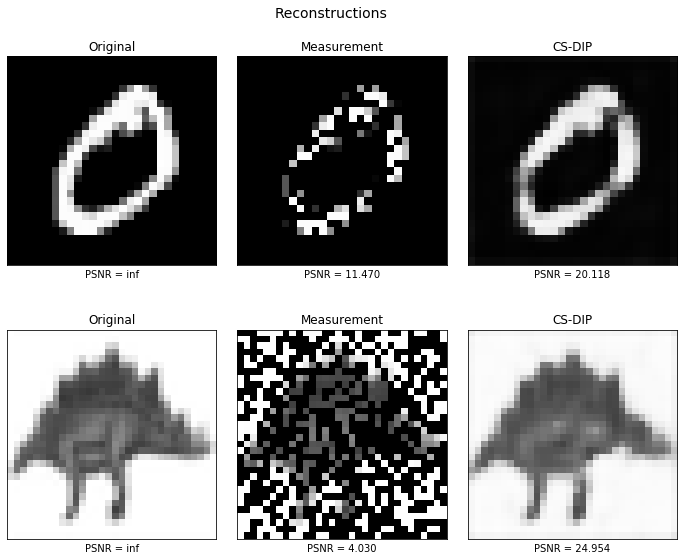

In [9]:
mnist_net = torch.load("mnist_net.pt")
cifar_net = torch.load("cifar_net.pt")

def plot_example(mnist_vecs, cifar_vecs, label):
    k=len(mnist_vecs)
    ogM=mnist_vecs[0].reshape(28,28)
    ogC=cifar_vecs[0].reshape(32,32)
    
    yM=mnist_vecs[1].reshape(28,28)
    yC=cifar_vecs[1].reshape(32,32)
    
    fig, axs = plt.subplots(2, k, figsize=(4*k, 8))
    fig.suptitle("Reconstructions", fontsize=14)
    if k==4:
        axs[1][3].imshow(cifar_vecs[3].reshape(32,32),cmap="gray", vmin=0, vmax=1)
        axs[1][3].set_title(label[1])
        axs[1][3].set_xlabel(f"PSNR = {PSNR(cifar_vecs[3].reshape(32,32),ogC):.3f}")
        axs[1][3].tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)

    axs[1][1].imshow(yC,cmap="gray", vmin=0, vmax=1)
    axs[1][1].set_title("Measurement")
    axs[1][1].set_xlabel(f"PSNR = {PSNR(yC,ogC):.3f}")
    axs[1][1].tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)

    axs[1][2].imshow(cifar_vecs[2].reshape(32,32),cmap="gray", vmin=0, vmax=1)
    axs[1][2].set_xlabel(f"PSNR = {PSNR(cifar_vecs[2].reshape(32,32),ogC):.3f}")
    axs[1][2].set_title(label[0])
    axs[1][2].tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)

    axs[1][0].imshow(ogC,cmap="gray", vmin=0, vmax=1)
    axs[1][0].set_xlabel(f"PSNR = {np.inf:.3f}")
    axs[1][0].set_title("Original")
    axs[1][0].tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)

    if k==4:
        axs[0][3].imshow(mnist_vecs[3].reshape(28,28),cmap="gray", vmin=0, vmax=1)
        axs[0][3].set_title(label[1])
        axs[0][3].set_xlabel(f"PSNR = {PSNR(mnist_vecs[3].reshape(28,28),ogM.reshape(28,28)):.3f}")
        axs[0][3].tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)

    axs[0][1].imshow(yM,cmap="gray", vmin=0, vmax=1)
    axs[0][1].set_title("Measurement")
    axs[0][1].set_xlabel(f"PSNR = {PSNR(yM,ogM):.3f}")
    axs[0][1].tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)

    axs[0][2].imshow(mnist_vecs[2].reshape(28,28),cmap="gray", vmin=0, vmax=1)
    axs[0][2].set_title(label[0])
    axs[0][2].set_xlabel(f"PSNR = {PSNR(mnist_vecs[2].reshape(28,28),ogM):.3f}")
    axs[0][2].tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)

    axs[0][0].imshow(ogM,cmap="gray", vmin=0, vmax=1)
    axs[0][0].set_title("Original")
    axs[0][0].set_xlabel(f"PSNR = {np.inf:.3f}")
    axs[0][0].tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)

    fig.subplots_adjust(top = 0.95, bottom=0, hspace=0, wspace=0.1)
    fig.show()

################ Change these values to plot different examples ############
    
sample_idx=1
measurments=0.4
    
############################################################################

vecC=cifar_data_vec[sample_idx]
vecM=mnist_data_vec[sample_idx]

CM=np.diag(np.random.rand(784)<measurments)
yM=CM@vecM
CC=np.diag(np.random.rand(1024)<measurments)
yC=CC@vecC

dctM = reconstruct(vecM, DCT_mnist, sparsity=0,plot=False,C=CM)
pcaM = reconstruct(vecM, PCA_mnist, sparsity=0,plot=False,C=CM)

dctC = reconstruct(vecC, DCT_cifar, sparsity=0,plot=False,C=CC)
pcaC = reconstruct(vecC, PCA_cifar, sparsity=0,plot=False,C=CC)

mnist_net.eval()
maskM=torch.tensor((CM@np.ones(784)).reshape(28,28))
inpM_img=torch.tensor(vecM.reshape(28,28))
inpM_img[(1-maskM).bool()]=0
inpM=torch.stack((inpM_img, 1-maskM),0).unsqueeze(0).to("cuda")
learnedM=mnist_net.forward(inpM).cpu().squeeze().detach().numpy()

cifar_net.eval()
maskC=torch.tensor((CC@np.ones(1024)).reshape(32,32))
inpC_img=torch.tensor(vecC.reshape(32,32))
inpC_img[(1-maskC).bool()]=0
inpC=torch.stack((inpC_img, 1-maskC),0).unsqueeze(0).to("cuda")
learnedC=cifar_net.forward(inpC).cpu().squeeze().detach().numpy()

unlearnedM=untrained(vecM,C=CM)
unlearnedC=untrained(vecC,C=CC)


plot_example([vecM,yM,dctM,pcaM],[vecC,yC,dctC,pcaC],["DCT","PCA"])
plot_example([vecM,yM,learnedM],[vecC,yC,learnedC],["U-net"])
plot_example([vecM,yM,unlearnedM],[vecC,yC,unlearnedC],["CS-DIP"])

### Code to generate the results

#### Evaluating sparsity of data

In [10]:
#Number of testing samples was reduced from 100 to 10

psnr_pixel=sparsity(mnist_data_vec)
psnr_dct=sparsity(mnist_data_vec, transform=dct, inv_transform=idct)
psnr_pca=sparsity(mnist_data_vec, transform=pca.transform, inv_transform=pca.inverse_transform)

psnr2_pixel=sparsity(cifar_data_vec)
psnr2_dct=sparsity(cifar_data_vec, transform=dct, inv_transform=idct)
psnr2_pca=sparsity(cifar_data_vec, transform=pca2.transform, inv_transform=pca2.inverse_transform)

C:\Users\phili\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


C:\Users\phili\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\phili\Anaconda3\lib\site-packages\ipykernel_launcher.py:95: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


21.84006454820115
18.087842654137624


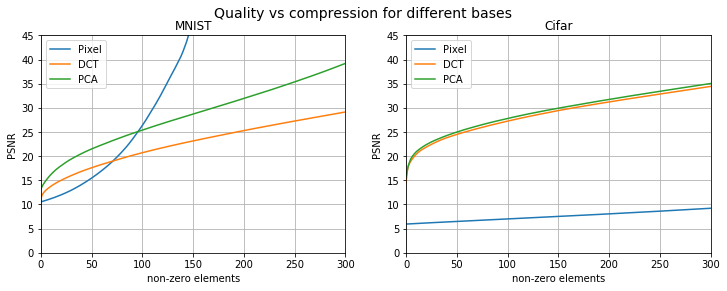

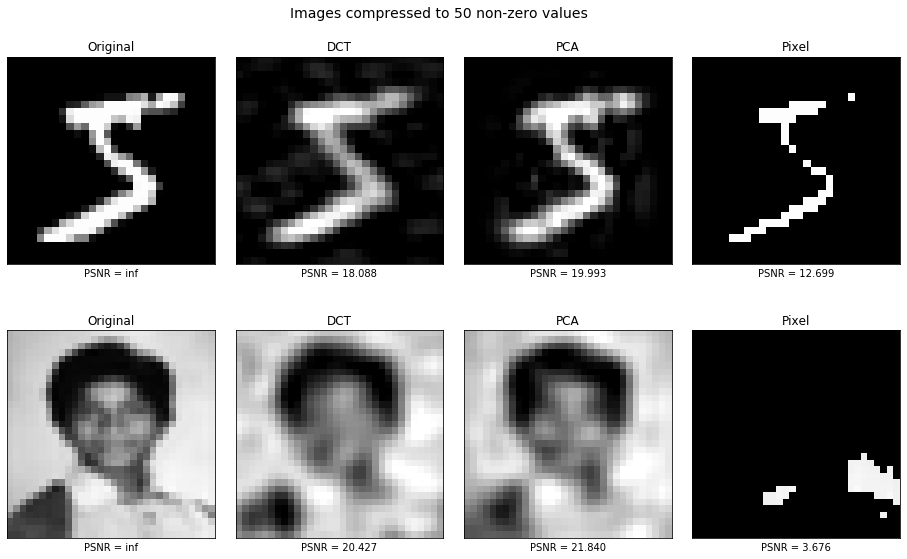

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))

fig.suptitle("Quality vs compression for different bases \n", fontsize=14,verticalalignment='top')
axs[0].plot(psnr_pixel)
axs[0].plot(psnr_dct)
axs[0].plot(psnr_pca)
axs[0].set_xlim((0,300))
axs[0].set_ylim((0,45))
axs[0].grid(True)
axs[0].set_title("MNIST")
axs[0].set_ylabel("PSNR")
axs[0].set_xlabel("non-zero elements")
axs[0].legend(["Pixel","DCT","PCA"])

axs[1].plot(psnr2_pixel)
axs[1].plot(psnr2_dct)
axs[1].plot(psnr2_pca)
axs[1].set_xlim((0,300))
axs[1].set_ylim((0,45))
axs[1].grid(True)
axs[1].set_title("Cifar")
axs[1].set_ylabel("PSNR")
axs[1].set_xlabel("non-zero elements")
axs[1].legend(["Pixel","DCT","PCA"],loc=2)

fig.show()

k_sparsity=50
vec1=compress(cifar_data_vec[3].copy(),k_sparsity)

vec2=dct(cifar_data_vec[3])
vec2=compress(vec2,k_sparsity)
vec2=idct(vec2)

vec3=pca2.transform(cifar_data_vec[:5])
compress(vec3[3],k_sparsity)
vec3=pca2.inverse_transform(vec3[:5])

vec4=compress(mnist_data_vec[0].copy(),k_sparsity)

vec5=dct(mnist_data_vec[0])
vec5=compress(vec5,k_sparsity)
vec5=idct(vec5)

vec6=pca.transform(mnist_data_vec[:5])
compress(vec6[0],k_sparsity)
vec6=pca.inverse_transform(vec6[:5])


fig, axs = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle("Images compressed to 50 non-zero values", fontsize=14)
axs[1][3].imshow(vec1.reshape(32,32),cmap="gray", vmin=0, vmax=1)
axs[1][3].set_title("Pixel")
axs[1][3].set_xlabel(f"PSNR = {PSNR(vec1,cifar_data_vec[3]):.3f}")
axs[1][3].tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)

axs[1][1].imshow(vec2.reshape(32,32),cmap="gray", vmin=0, vmax=1)
axs[1][1].set_title("DCT")
axs[1][1].set_xlabel(f"PSNR = {PSNR(vec2,cifar_data_vec[3]):.3f}")
axs[1][1].tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)

axs[1][2].imshow(vec3[3].reshape(32,32),cmap="gray", vmin=0, vmax=1)
axs[1][2].set_xlabel(f"PSNR = {PSNR(vec3[3],cifar_data_vec[3]):.3f}")
axs[1][2].set_title("PCA")
axs[1][2].tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)

axs[1][0].imshow(cifar_data_vec[3].reshape(32,32),cmap="gray", vmin=0, vmax=1)
axs[1][0].set_xlabel(f"PSNR = {np.inf:.3f}")
axs[1][0].set_title("Original")
axs[1][0].tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)

axs[0][3].imshow(vec4.reshape(28,28),cmap="gray", vmin=0, vmax=1)
axs[0][3].set_title("Pixel")
axs[0][3].set_xlabel(f"PSNR = {PSNR(vec4,mnist_data_vec[0]):.3f}")
axs[0][3].tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)

axs[0][1].imshow(vec5.reshape(28,28),cmap="gray", vmin=0, vmax=1)
axs[0][1].set_title("DCT")
axs[0][1].set_xlabel(f"PSNR = {PSNR(vec5,mnist_data_vec[0]):.3f}")
axs[0][1].tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)

axs[0][2].imshow(vec6[0].reshape(28,28),cmap="gray", vmin=0, vmax=1)
axs[0][2].set_title("PCA")
axs[0][2].set_xlabel(f"PSNR = {PSNR(vec6[0],mnist_data_vec[0]):.3f}")
axs[0][2].tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)

axs[0][0].imshow(mnist_data_vec[0].reshape(28,28),cmap="gray", vmin=0, vmax=1)
axs[0][0].set_title("Original")
axs[0][0].set_xlabel(f"PSNR = {np.inf:.3f}")
axs[0][0].tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)

print(PSNR(vec3[3],cifar_data_vec[3]))
print(PSNR(vec5,mnist_data_vec[0]))
fig.subplots_adjust(top = 0.95, bottom=0, hspace=0, wspace=0.1)
fig.show()


#### Training the U-nets

162049


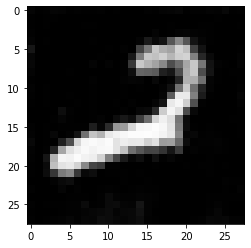

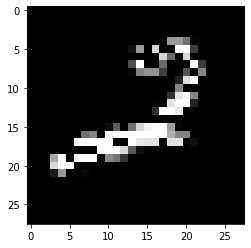

0.05503684711339125 0.022355329619249145
0.6008051658163265


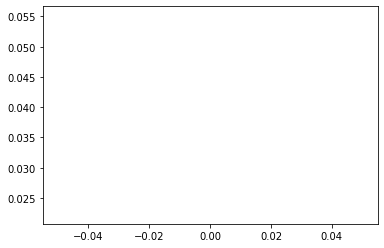

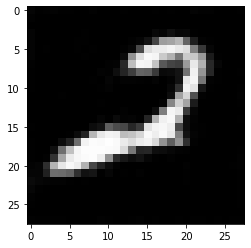

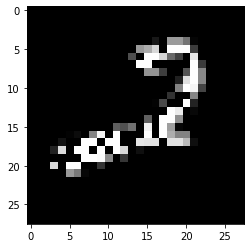

0.019475751756973147 0.02011925059903858
0.6397879464285714


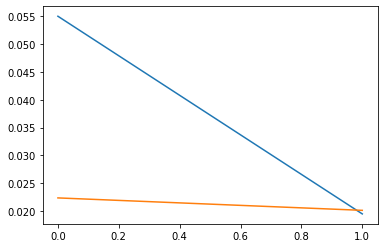

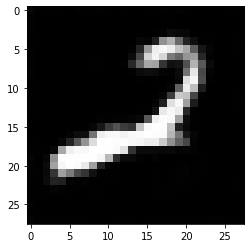

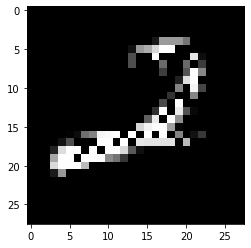

0.01728836923565794 0.017484350693186063
0.6871213329081632


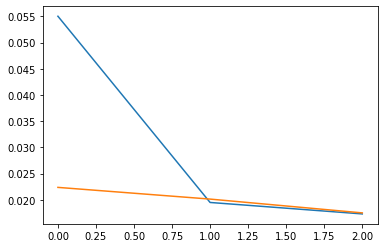

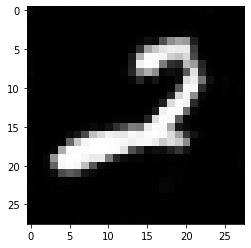

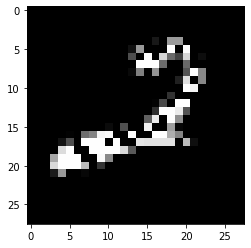

0.015291241803430777 0.016432886163104416
0.6261957908163265


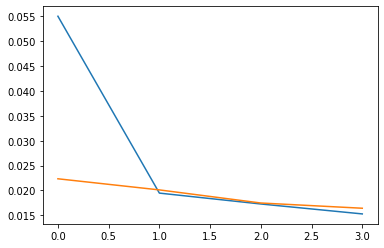

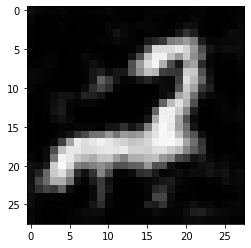

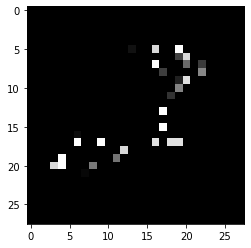

0.015071025556812225 0.014674077051151794
0.13911033163265307


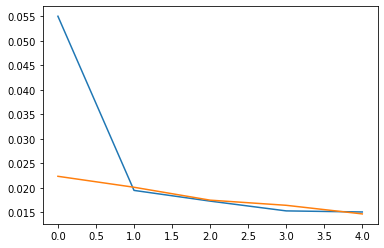

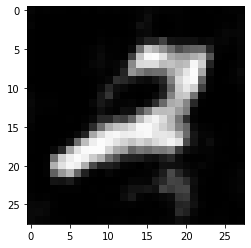

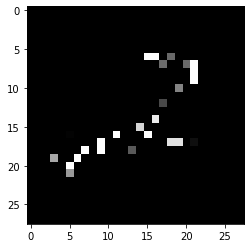

0.01452803943187977 0.014602534230297693
0.16920440051020408


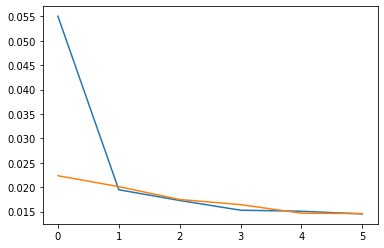

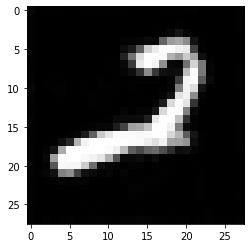

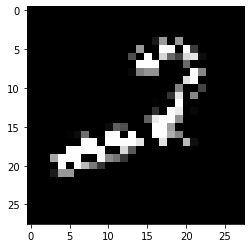

0.01320807494744099 0.013737925410080929
0.6121651785714286


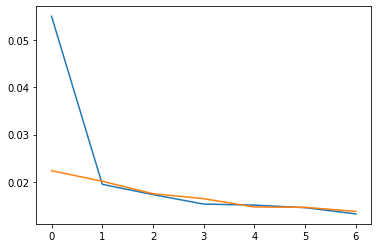

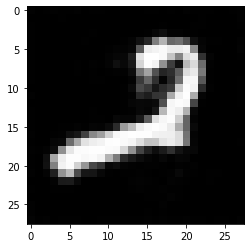

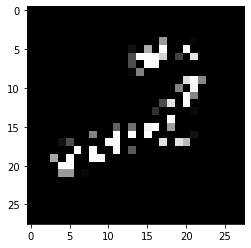

0.01266199525786112 0.0130106974264296
0.37936463647959184


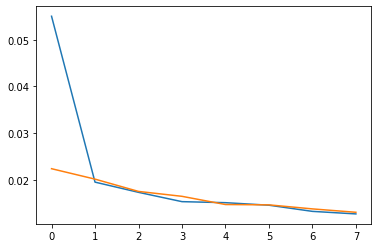

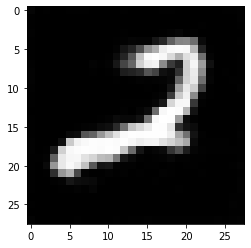

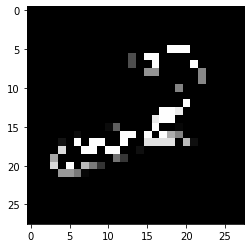

0.012505418521377099 0.01236565972251804
0.4766422193877551


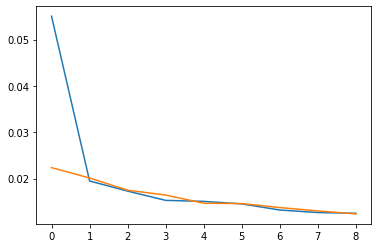

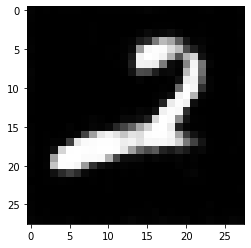

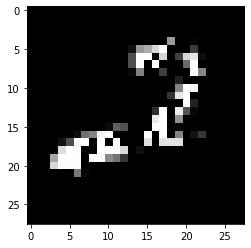

0.01245603711539974 0.011816761833115795
0.6941964285714286


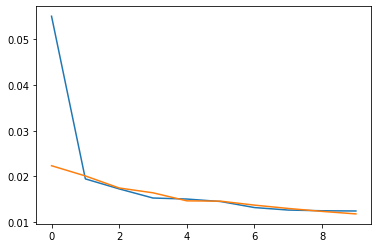

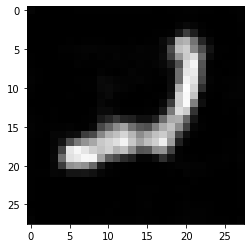

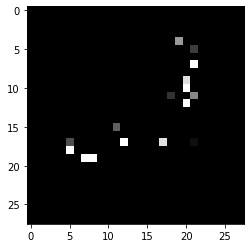

0.011938850318205792 0.011866887020174098
0.1237045599489796


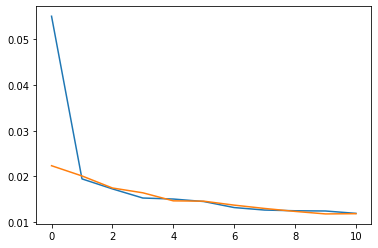

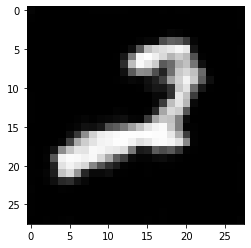

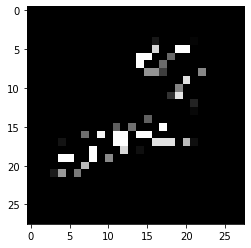

0.01194357985743801 0.01186662331431346
0.3464405293367347


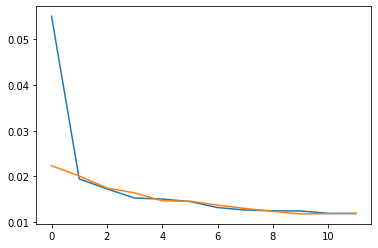

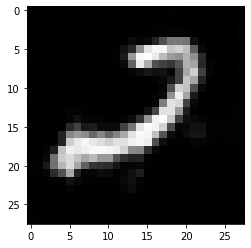

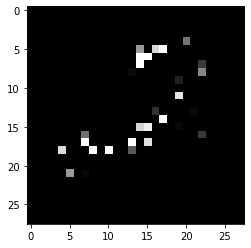

0.011513695452228837 0.009971098094145323
0.2347735969387755


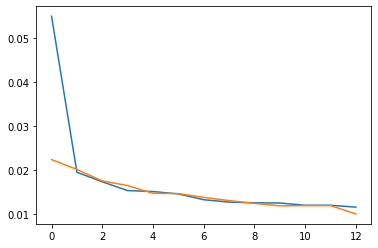

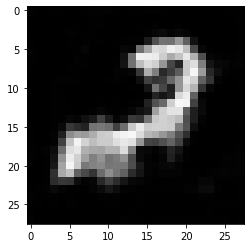

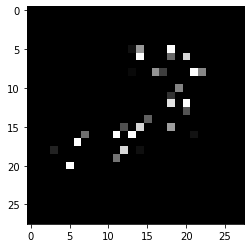

0.011639234230860704 0.012645843407903872
0.13454639668367346


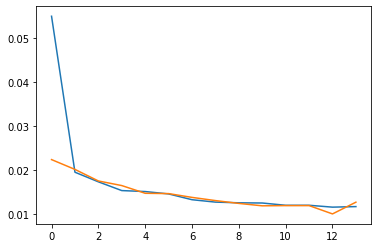

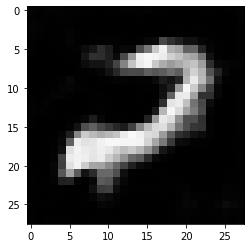

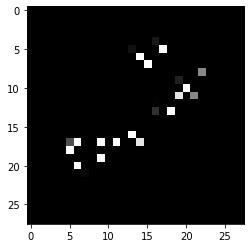

0.011081603438319407 0.01157503014202163
0.18761957908163265


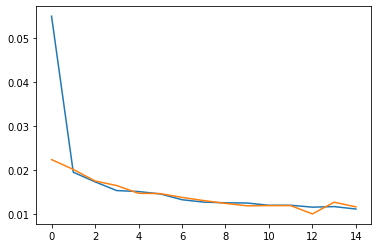

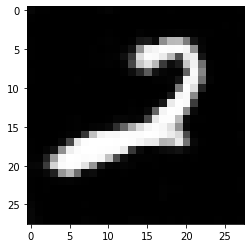

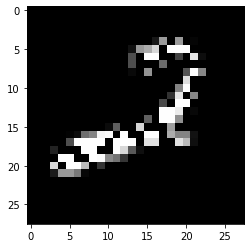

0.011412436612941305 0.009898193080421166
0.5713289221938775


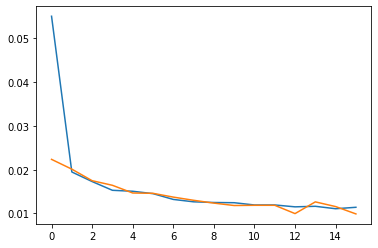

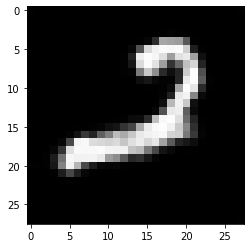

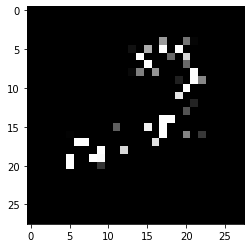

0.010538390920494 0.012427666712892622
0.32370057397959184


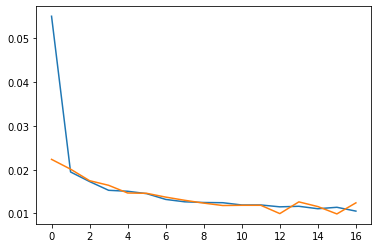

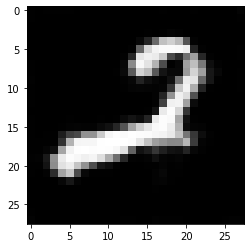

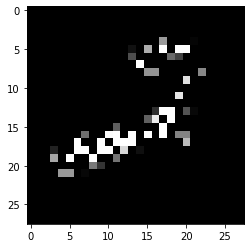

0.011289202406223905 0.011610900511794234
0.38560267857142855


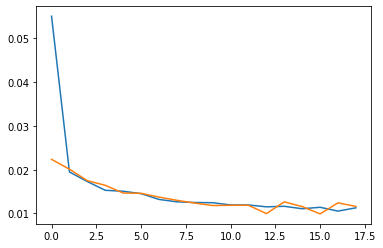

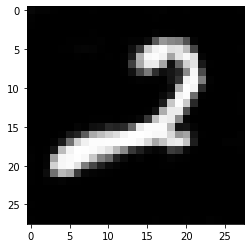

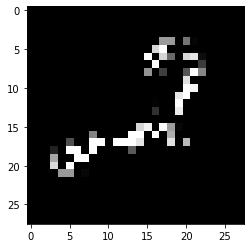

0.010366599899068596 0.010940362058236227
0.4226124043367347


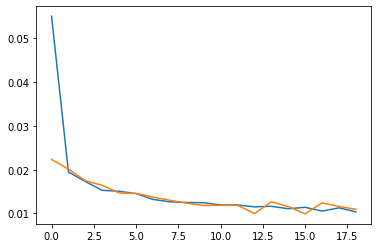

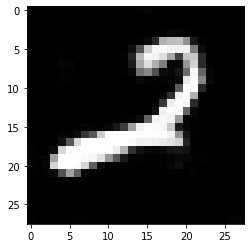

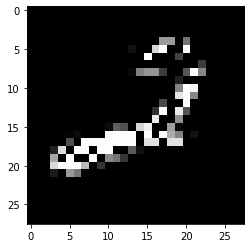

0.0102387096489833 0.010341088249915312
0.5950653698979592


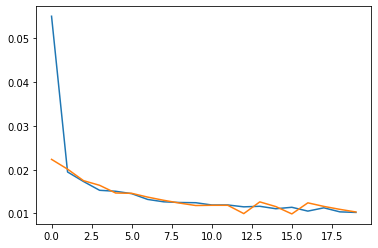

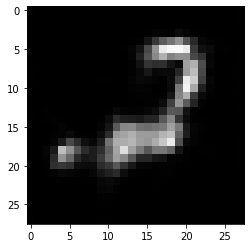

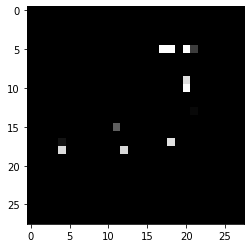

0.010026864603454734 0.011630125966910536
0.1132015306122449


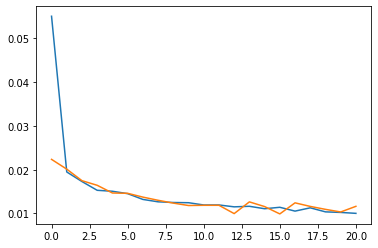

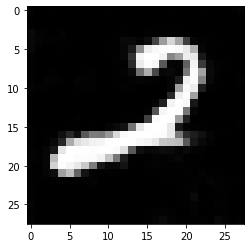

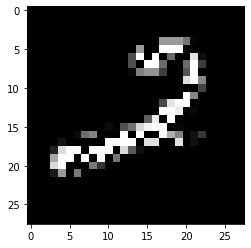

0.010435270692738722 0.010085162856877985
0.6432158801020408


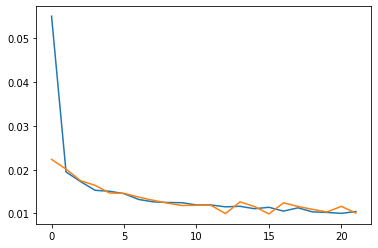

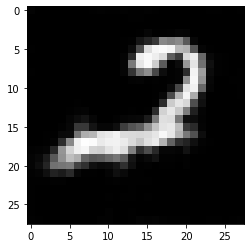

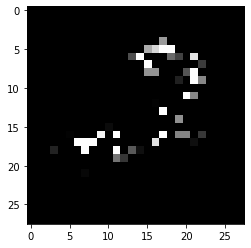

0.010348119324708529 0.01068387134606283
0.4013671875


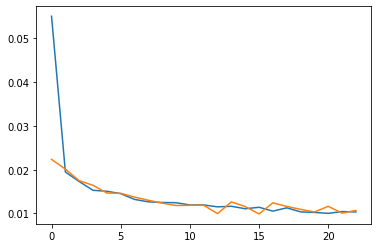

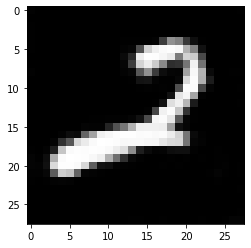

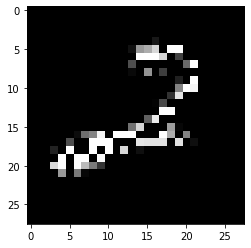

0.010249282327403951 0.010930203280764621
0.43887515943877553


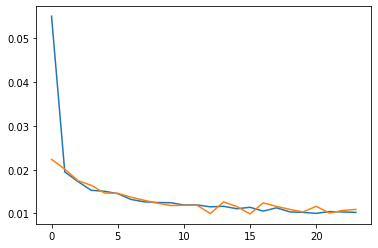

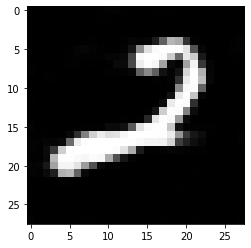

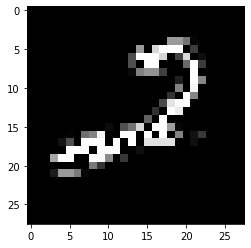

0.010351459796372241 0.011771981029798734
0.5969786352040817


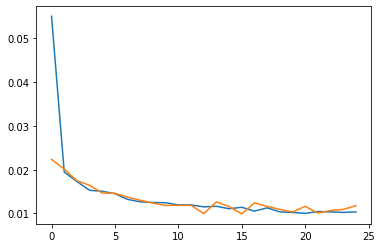

1730.801362991333
162049


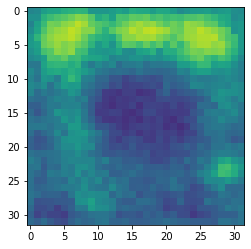

0.02356531040234231 0.014251410879814966


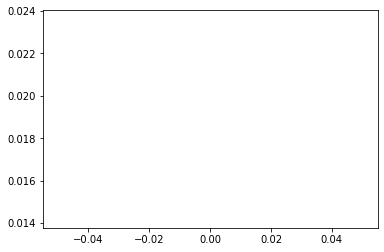

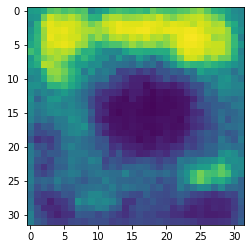

0.011748836254861169 0.01195113920229836


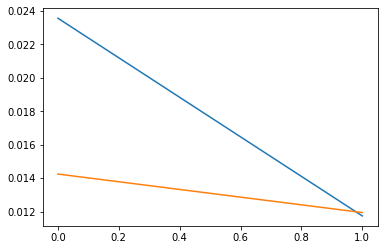

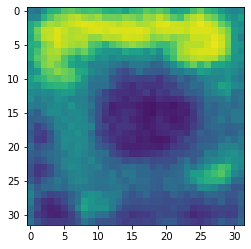

0.009850331548746528 0.009343147131883828


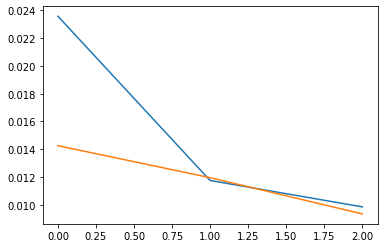

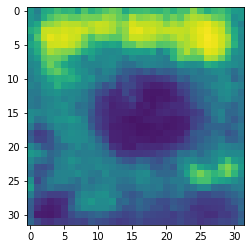

0.008476669908642926 0.008746948213119716


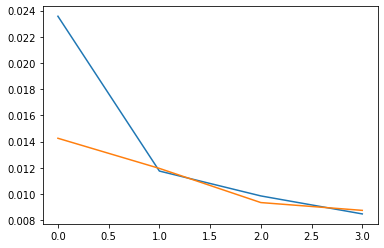

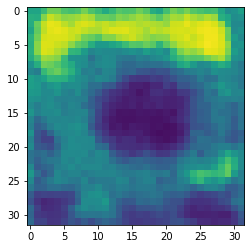

0.008023824554711163 0.007329000518364091


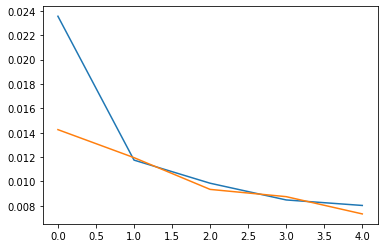

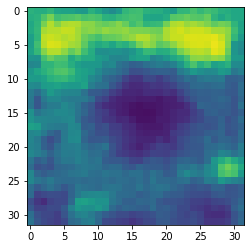

0.007501971356876262 0.00726556582648958


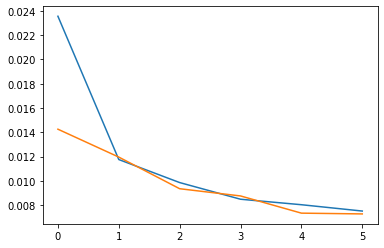

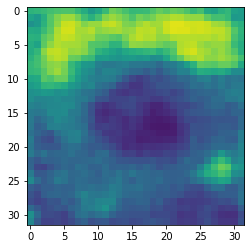

0.007429419989985311 0.006770598005895796


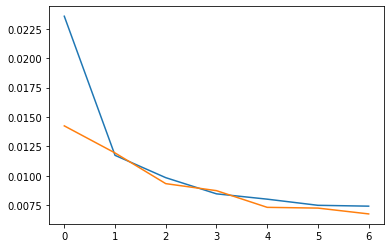

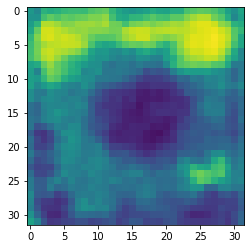

0.00693920278656436 0.006520962904834364


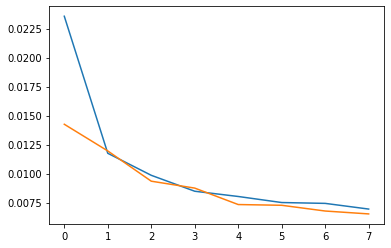

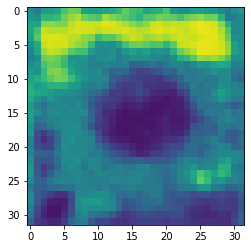

0.006614446601627842 0.006207199756847852


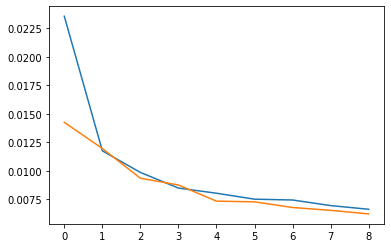

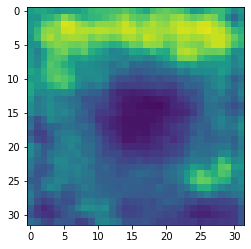

0.006411104899403716 0.006827538555592609


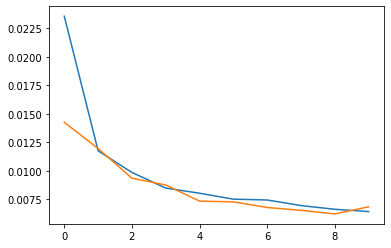

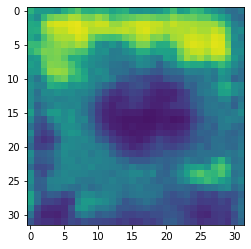

0.006217254471526181 0.006123523208684091


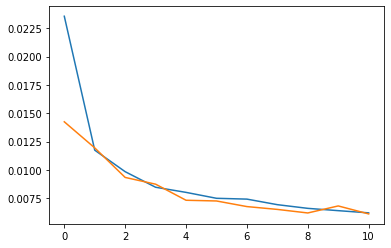

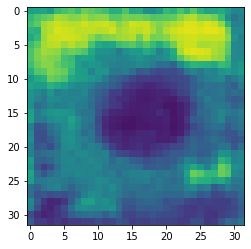

0.006185173956955287 0.006394830962359845


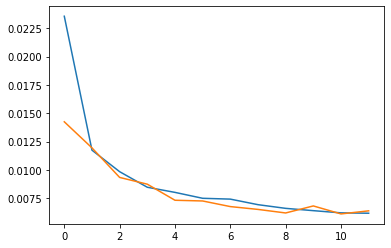

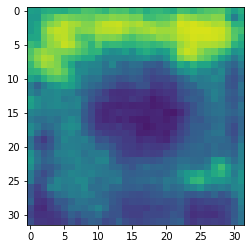

0.006108383458225601 0.006518535707978867


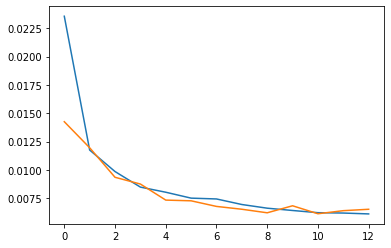

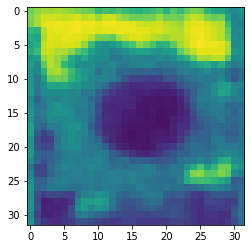

0.0060629344343881295 0.006397219283679583


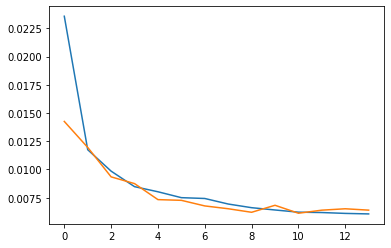

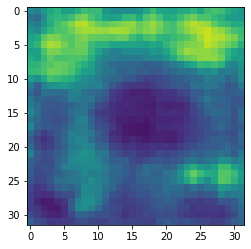

0.005752409218327209 0.00663202990745154


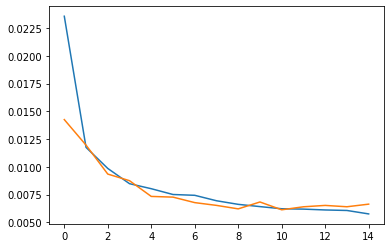

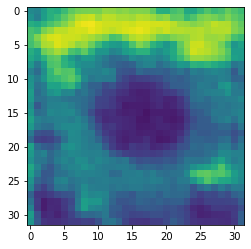

0.005839204476762145 0.00538198267536989


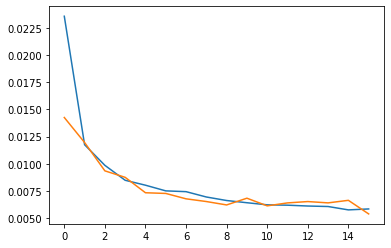

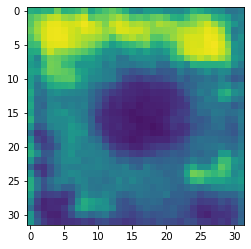

0.005654821925832361 0.005309342398275687


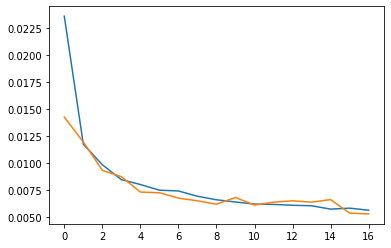

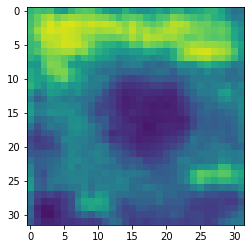

0.0058040304888047015 0.005679654438175857


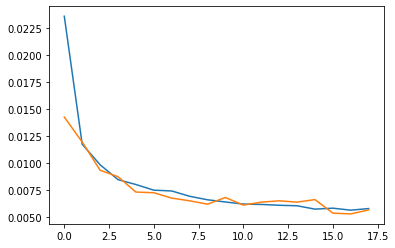

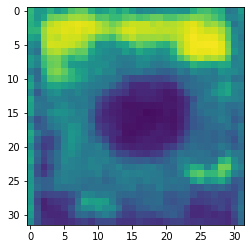

0.00553323396193255 0.005733161387815893


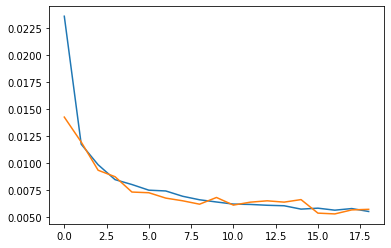

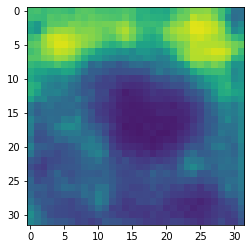

0.005588653138417637 0.006045694539293526


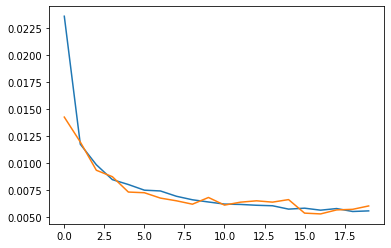

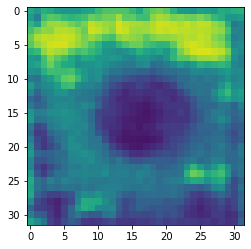

0.005591441023323526 0.005360040977196282


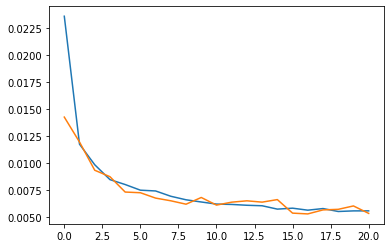

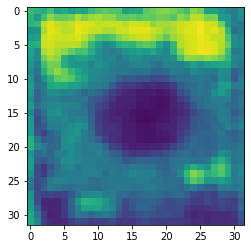

0.005489773979264871 0.005228843286429643


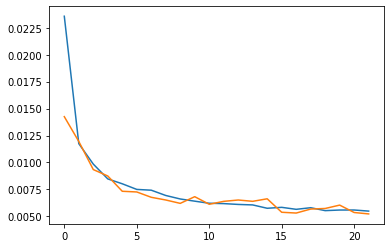

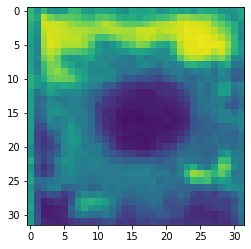

0.00525948458934212 0.005461452104368466


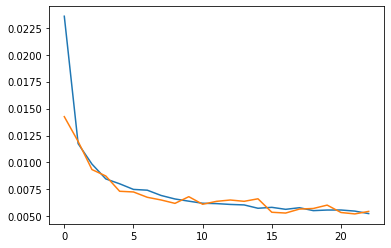

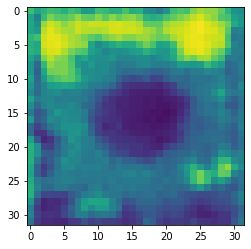

0.0053034821190849615 0.005117512713178988


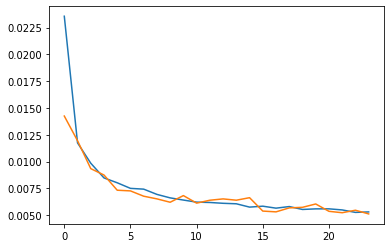

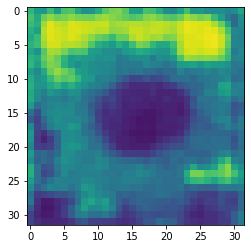

0.005242487248758523 0.0052031490608187


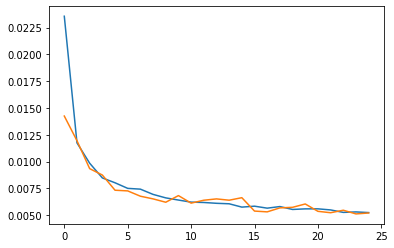

2201.633725643158


In [12]:
mnist_net=U_Net().double().to("cuda")
torch.backends.cudnn.benchmark = True
print(count_parameters(mnist_net))
loss_graph=[] #used to display the loss over time
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001, momentum=0.98)
batch_size=64
train_batches=torch.split(torch.tensor(mnist_data[:50000]),batch_size)[:-1]
test_batches=torch.split(torch.tensor(mnist_data[50000:]),batch_size)[:-1]
n=784
sparse_low=0.1
sparse_high=0.7

start=time.time()
for e in range(25):
    mnist_net.train()
    train_loss=[]
    
    for batch in train_batches:
        mask=np.random.uniform(size=(batch_size,28,28))<np.random.uniform(low=1-sparse_high, high=1-sparse_low)
        target=batch.clone().to("cuda")
        inp=batch.clone()
        mask=torch.tensor(mask)
        inp[mask]=0
        inp=torch.stack((inp, mask),1).to("cuda")
        out=mnist_net.forward(inp)
        loss=F.mse_loss(out,target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        
    with torch.no_grad():
        mnist_net.eval()
        test_loss=[]
        
        for batch in test_batches:
            mask=np.random.uniform(size=(batch_size,28,28))<np.random.uniform(low=1-sparse_high, high=1-sparse_low)
            target=batch.clone().to("cuda")
            inp=batch.clone()
            mask=torch.tensor(mask)
            inp[mask]=0
            inp=torch.stack((inp, mask),1).to("cuda")
            out=mnist_net.forward(inp)
            loss=F.mse_loss(out,target)
            test_loss.append(loss.item())
        
        plt.imshow(out.cpu().detach().numpy()[0],cmap="gray",vmin=0,vmax=1)
        plt.show()
        plt.imshow(inp.cpu().detach().numpy()[0][0],cmap="gray",vmin=0,vmax=1)
        plt.show()
        print(np.mean(train_loss),np.mean(test_loss))
        print(np.sum(1-mask.int().cpu().numpy())/(64*784))
        loss_graph.append((np.mean(train_loss),np.mean(test_loss)))
        plt.plot(loss_graph)
        plt.show()
        
end=time.time()
print(end-start)


cifar_net=U_Net().double().to("cuda")
torch.backends.cudnn.benchmark = True
print(count_parameters(cifar_net))
loss_graph_cifar=[] #used to display the loss over time
optimizer = optim.SGD(cifar_net.parameters(), lr=0.001, momentum=0.98)
batch_size=64
train_batches=torch.split(torch.tensor(cifar_data[:50000]),batch_size)[:-1]
test_batches=torch.split(torch.tensor(cifar_data[50000:]),batch_size)[:-1]
n=1024
sparse_low=0.1
sparse_high=0.7

start=time.time()
for e in range(25):
    cifar_net.train()
    train_loss=[]
    
    for batch in train_batches:
        mask=np.random.uniform(size=(batch_size,32,32))<np.random.uniform(low=1-sparse_high, high=1-sparse_low)
        target=batch.clone().to("cuda")
        inp=batch.clone()
        mask=torch.tensor(mask)
        inp[mask]=0
        inp=torch.stack((inp, mask),1).to("cuda")
        out=cifar_net.forward(inp)
        loss=F.mse_loss(out,target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        
    with torch.no_grad():
        cifar_net.eval()
        test_loss=[]
        
        for batch in test_batches:
            mask=np.random.uniform(size=(batch_size,32,32))<np.random.uniform(low=1-sparse_high, high=1-sparse_low)
            target=batch.clone().to("cuda")
            inp=batch.clone()
            mask=torch.tensor(mask)
            inp[mask]=0
            inp=torch.stack((inp, mask),1).to("cuda")
            out=cifar_net.forward(inp)
            loss=F.mse_loss(out,target)
            test_loss.append(loss.item())
        
        plt.imshow(out.cpu().detach().numpy()[0],vmin=0,vmax=1)
        plt.show()
        print(np.mean(train_loss),np.mean(test_loss))
        loss_graph_cifar.append((np.mean(train_loss),np.mean(test_loss)))
        plt.plot(loss_graph_cifar)
        plt.show()
        
end=time.time()
print(end-start)

#### Evaluating reconstruction quality

In [14]:
#Number of testing samples was reduced from 100 to 10
#Since the measurements are random there is a lot of uncertainty in the result with only 10 samples

DCT_mnist_psnrs,DCT_mnist_avg_time=test_method(mnist_data_vec[50000:],DCT_mnist)
print(DCT_mnist_avg_time)
PCA_mnist_psnrs,PCA_mnist_avg_time=test_method(mnist_data_vec[50000:],PCA_mnist)
print(PCA_mnist_avg_time)
DCT_cifar_psnrs,DCT_cifar_avg_time=test_method(cifar_data_vec[50000:],DCT_cifar)
print(DCT_cifar_avg_time)
PCA_cifar_psnrs,PCA_cifar_avg_time=test_method(cifar_data_vec[50000:],PCA_cifar)
print(PCA_cifar_avg_time)

Unet_mnist_psnrs,Unet_mnist_avg_time=test_method(mnist_data_vec[50000:],net=mnist_net)
print(Unet_mnist_avg_time)
Unet_cifar_psnrs,Unet_cifar_avg_time=test_method(cifar_data_vec[50000:],net=cifar_net)
print(Unet_cifar_avg_time)

DIP_mnist_psnrs,DIP_mnist_avg_time=test_method(mnist_data_vec[50000:],untrained=untrained)
print(DIP_mnist_avg_time)
DIP_cifar_psnrs,DIP_cifar_avg_time=test_method(cifar_data_vec[50000:],untrained=untrained)
print(DIP_cifar_avg_time)

1.536329323904855
1.3918983459472656
2.899575069972447
3.1247571059635706
0.01060316903250558
0.008639604704720633
3.586603035245623
3.581680907521929


C:\Users\phili\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


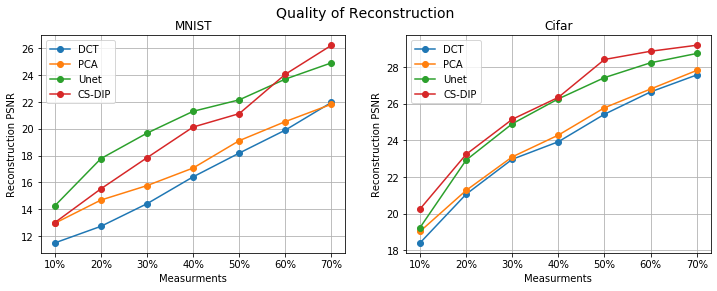

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))

fig.suptitle("Quality of Reconstruction", fontsize=14,verticalalignment='top')
axs[0].plot(DCT_mnist_psnrs,marker='o')
axs[0].plot(PCA_mnist_psnrs,marker='o')
axs[0].plot(Unet_mnist_psnrs,marker='o')
axs[0].plot(DIP_mnist_psnrs,marker='o')
axs[0].grid(True)
axs[0].set_title("MNIST")
axs[0].set_xlabel("Measurments")
axs[0].set_ylabel("Reconstruction PSNR")
axs[0].set_xticklabels(labels=['0','10%','20%','30%','40%','50%','60%','70%'])
axs[0].legend(["DCT","PCA","Unet","CS-DIP"])

axs[1].plot(DCT_cifar_psnrs,marker='o')
axs[1].plot(PCA_cifar_psnrs,marker='o')
axs[1].plot(Unet_cifar_psnrs,marker='o')
axs[1].plot(DIP_cifar_psnrs,marker='o')
axs[1].grid(True)
axs[1].set_title("Cifar")
axs[1].set_xlabel("Measurments")
axs[1].set_ylabel("Reconstruction PSNR")
axs[1].set_xticklabels(labels=['0','10%','20%','30%','40%','50%','60%','70%'])
axs[1].legend(["DCT","PCA","Unet","CS-DIP"])

fig.show()